# Cold snap in Texas February 2021

On 16th Feb BBC writes:
"""Texas is known for its sprawling deserts and excruciating heatwaves - but right now, it's blanketed in a thick layer of ice.

The state is seeing some of its coldest temperatures in more than 30 years, with some areas breaking records that are more than a century old.

Parts of Texas hit 0F (-18C) on Sunday, and weather warnings are going to stay in place through the week.

So why is this normally boiling state suddenly freezing over?

According to the US National Weather Service (NWS), this is down to an "Arctic outbreak" that originated just above the US-Canada border, bringing a winter snow storm as well as plummeting temperatures.

Cold air outbreaks such as these are normally kept in the Arctic by a series of low-pressure systems, the NWS said. However, this one moved through Canada and spilled out into the US last week.

Temperatures in the city of Dallas for example will reach a high of 14F (-10C) on Monday when it should be more like 59F (15C) at this time of year.

For the first time in the US state, all 254 counties are under a winter storm warning, US media report. The temperature in Dallas is already colder than in Anchorage, Alaska, CBS News reports."""

We decided to use ECMWF ERA5 dataset to look closer into the data behind those cold temperatures. We are going to use ERA5 in zarr format. 
Zarr is a new storage format which, thanks to its simple yet well-designed specification, makes large datasets easily accessible to distributed computing. In Zarr datasets, the arrays are divided into chunks and compressed. These individual chunks can be stored as files on a filesystem or as objects in a cloud storage bucket. The metadata are stored in lightweight .json files. Zarr works well on both local filesystems and cloud-based object stores. Existing datasets can easily be converted to zarr via xarray’s zarr functions.

In this Notebook we will:
* Read in data from S3 using zarr format
* Make animation of cold from moving from Arctic to the us southern states
* Make long time (1990-2021) timeseries graph from Texas to see how temperatures has changed over time. 
* Look into January and February temperatures in texas

In [1]:
%matplotlib notebook
%matplotlib inline
import xarray as xr
import datetime
import numpy as np
from dask.distributed import LocalCluster, Client
import s3fs
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import boto3
import matplotlib.pyplot as plt
import os
import pandas as pd
import imageio
import shutil
from matplotlib.dates import MonthLocator, DayLocator, YearLocator
from matplotlib.ticker import MultipleLocator
from matplotlib import colors as c
import salem
import warnings
import multiprocessing.popen_spawn_posix
from distributed import Client
warnings.filterwarnings("ignore")

First we define some variables for reading zarr

In [2]:
bucket = 'era5-pds'
client = boto3.client('s3')
var = 'air_temperature_at_2_metres'
client = Client()
client

Client Scheduler: tcp://127.0.0.1:60956 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 32.15 GB


In [3]:
fs = s3fs.S3FileSystem(anon=False)

Here we define some functions to read in zarr data.

In [4]:
def inc_mon(indate):
    if indate.month < 12:
        return datetime.datetime(indate.year, indate.month+1, 1)
    else:
        return datetime.datetime(indate.year+1, 1, 1)

def gen_d_range(start, end):
    rr = []
    while start <= end:
        rr.append(start)
        start = inc_mon(start)
    return rr

def get_z(dtime,var):
    f_zarr = 'era5-pds/zarr/{year}/{month:02d}/data/{var}.zarr/'.format(year=dtime.year, month=dtime.month,var=var)
    return xr.open_zarr(s3fs.S3Map(f_zarr, s3=fs),consolidated=True)

def gen_zarr_range(start, end,var):
    return [get_z(tt,var) for tt in gen_d_range(start, end)]

This is where we read in the data. We need to define the time range and variable name. At first, we will choose to select area over Northern hemisphere and some part of southern to make globe animation from February.

In [5]:
def get_zarr_data(time_start, time_end, var, longitude_west, longitude_east, latitude_north, latitude_south):
    tmp_a = gen_zarr_range(time_start, time_end,var)
    tmp_all = xr.concat(tmp_a, dim='time0')
    temperature = tmp_all[var].sel(lon=slice(longitude_east, longitude_west),lat=slice(latitude_north,latitude_south))
    if 'temp' in var:
        temperature = temperature- 272.15
    lon = temperature.lon.values; lat = temperature.lat.values
    return lon, lat, temperature

Here we will read in data for the animation. You can change the time range, but note that the data is with an hour resolution, so it will take some time. 

In [13]:
%%time
lon,lat,temperature = get_zarr_data(datetime.datetime(2021,2,10), datetime.datetime(2021,2,18),var,360, 0, 90, -26) 

CPU times: user 48.3 ms, sys: 0 ns, total: 48.3 ms
Wall time: 284 ms


In [14]:
def make_globe_imgs(lon, lat, data, img_out,timevar,colorbar_name):
    us_shapes = list(shpreader.Reader('shapefiles/gadm36_USA_shp/gadm36_USA_1.shp').geometries())
    plt.ioff()
    for i in range(0,len(data[timevar])):
        order_nr = str(i).rjust(3,'0')
        img_name = f'{img_out}/{order_nr}_temp.png'
        if os.path.exists(img_name):
            continue  
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111,projection=ccrs.Orthographic(-103,60))
        
        ax.set_global()
        ax.gridlines()
        ax.add_geometries(us_shapes,ccrs.PlateCarree(), edgecolor='#222933',linewidth=0.5,facecolor='none')
        ax.add_feature(cartopy.feature.BORDERS,color='#222933',linewidth=0.5)
        ax.add_feature(cartopy.feature.COASTLINE,color='#222933',linewidth=0.5)
        
        tmp = data[i].compute()
    
        t = pd.to_datetime(str(data[i][timevar].values)) 
        timestring = t.strftime('%b %d %Y %H:%M')
        print ('tmp',timestring)
        pcm = ax.pcolormesh(lon,lat,tmp,vmin=-35,vmax=35,cmap='RdYlBu_r',transform=ccrs.PlateCarree())
        S1 = ax.contour(lon,lat,tmp,[0],colors='black',linewidths=0.4,alpha = 0.6,transform=ccrs.PlateCarree()) #0 line
        
        cbar = plt.colorbar(pcm,fraction=0.019, pad=0.03)
        cbar.set_label(colorbar_name)
    
        ttl = plt.title(timestring,fontsize=20,fontweight = 'bold',y=1.05)
        
        plt.savefig(img_name,bbox_inches = 'tight',dpi=200)
        
        plt.close()

In [15]:
img_out = 'texas_imgs'
if not os.path.exists(img_out):
    os.mkdir(img_out)

This is where we start making images for the animation. 

In [16]:
%%time
make_globe_imgs(lon, lat, temperature,img_out, 'time0','Temperature [°C]')

tmp Feb 01 2021 01:00
tmp Feb 01 2021 02:00
tmp Feb 01 2021 03:00
tmp Feb 01 2021 04:00
tmp Feb 01 2021 05:00
tmp Feb 01 2021 06:00
tmp Feb 01 2021 07:00
tmp Feb 01 2021 08:00
tmp Feb 01 2021 09:00
tmp Feb 01 2021 10:00
tmp Feb 01 2021 11:00
tmp Feb 01 2021 12:00
tmp Feb 01 2021 13:00
tmp Feb 01 2021 14:00
tmp Feb 01 2021 15:00
tmp Feb 01 2021 16:00
tmp Feb 01 2021 17:00
tmp Feb 01 2021 18:00
tmp Feb 01 2021 19:00
tmp Feb 01 2021 20:00
tmp Feb 01 2021 21:00
tmp Feb 01 2021 22:00
tmp Feb 01 2021 23:00
tmp Feb 02 2021 00:00
tmp Feb 02 2021 01:00
tmp Feb 02 2021 02:00
tmp Feb 02 2021 03:00
tmp Feb 02 2021 04:00
tmp Feb 02 2021 05:00
tmp Feb 02 2021 06:00
tmp Feb 02 2021 07:00
tmp Feb 02 2021 08:00
tmp Feb 02 2021 09:00
tmp Feb 02 2021 10:00
tmp Feb 02 2021 11:00
tmp Feb 02 2021 12:00
tmp Feb 02 2021 13:00
tmp Feb 02 2021 14:00
tmp Feb 02 2021 15:00
tmp Feb 02 2021 16:00
tmp Feb 02 2021 17:00
tmp Feb 02 2021 18:00
tmp Feb 02 2021 19:00
tmp Feb 02 2021 20:00
tmp Feb 02 2021 21:00
tmp Feb 02

tmp Feb 16 2021 14:00
tmp Feb 16 2021 15:00
tmp Feb 16 2021 16:00
tmp Feb 16 2021 17:00
tmp Feb 16 2021 18:00
tmp Feb 16 2021 19:00
tmp Feb 16 2021 20:00
tmp Feb 16 2021 21:00
tmp Feb 16 2021 22:00
tmp Feb 16 2021 23:00
tmp Feb 17 2021 00:00
tmp Feb 17 2021 01:00
tmp Feb 17 2021 02:00
tmp Feb 17 2021 03:00
tmp Feb 17 2021 04:00
tmp Feb 17 2021 05:00
tmp Feb 17 2021 06:00
tmp Feb 17 2021 07:00
tmp Feb 17 2021 08:00
tmp Feb 17 2021 09:00
tmp Feb 17 2021 10:00
tmp Feb 17 2021 11:00
tmp Feb 17 2021 12:00
tmp Feb 17 2021 13:00
tmp Feb 17 2021 14:00
tmp Feb 17 2021 15:00
tmp Feb 17 2021 16:00
tmp Feb 17 2021 17:00
tmp Feb 17 2021 18:00
tmp Feb 17 2021 19:00
tmp Feb 17 2021 20:00
tmp Feb 17 2021 21:00
CPU times: user 43min 2s, sys: 2min 20s, total: 45min 23s
Wall time: 1h 8min 4s


In [17]:
def make_animation(img_out_folder):   
    files = [f for f in sorted(os.listdir(img_out_folder))]
    
    fileList = []
    for file in files:
        if not file.startswith('.'):
            complete_path = f"{img_out}/{file}"
            fileList.append(complete_path)
    writer = imageio.get_writer('era5_us_cold_wave.mp4', fps=8)
    
    for im in fileList:
        writer.append_data(imageio.imread(im))
    writer.close()

Now we will make animation of all the images.

In [18]:
make_animation(img_out)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1441, 1367) to (1456, 1376) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [19]:
def make_plot(data,dataset_key1,title,unit,**kwargs):
    plt.ion()

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    if 'daily' in kwargs:
        if kwargs['daily'] == True:
            data_time = data['time0']
    else:
        data_time = data['time0.year']
    if 'trend' in kwargs:  
        z = np.polyfit(data_time, data, 1)
        p = np.poly1d(z)
        plt.plot(data_time,p(data_time),"r--",c='#1B9AA0')        
    plt.plot(data_time,data, linestyle = '-',marker='*',linewidth = 1,c='#EC5840',label = dataset_key1) 
            
    plt.grid(color='#C3C8CE',alpha=1)

    if 'locator' in kwargs:
        ml = MultipleLocator(kwargs['locator'][1])
        bl = MultipleLocator(kwargs['locator'][0])
    else:
        ml = MultipleLocator(1)
        bl = MultipleLocator(5)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.set_major_locator(bl)

    #plt.minorticks_on()
    if len(kwargs) > 0:
        if 'ylabel' in kwargs:
            plt.ylabel(kwargs['ylabel'],fontsize=15)
    
        if 'xlabel' in kwargs:
            plt.ylabel(kwargs['xlabel'],fontsize=15)
   
        if 'compare_line' in kwargs:
            props = dict(boxstyle='round', facecolor='#1B9AA0',edgecolor='#1B9AA0')
            ax.text(max(data_time) + 1,kwargs['compare_line'],str("%.1f" % kwargs['compare_line']) + unit,verticalalignment='center',bbox = props,color='white')
            ax.plot([min(data_time) - 1,max(data_time) + 1], [kwargs['compare_line'],kwargs['compare_line']], '-',linewidth = 2, c='#1B9AA0', label = 'w0 year average temperature')
        if 'ylim' in kwargs:
            plt.ylim(np.min(kwargs['ylim']),np.max(kwargs['ylim']))
    plt.xticks(rotation = 0)
    
    try:
        plt.xlim(np.min(data_time)-0.5,np.max(data_time)+0.5)
    except:
        pass
    ttl = plt.title(title,fontsize=20,fontweight = 'bold',y = 1.05)

    plt.savefig('plot_out' + title + '.png', dpi=300,transparent=False)
    plt.show()
    plt.close()

Here, at first we will define approximate Texas boarders, but also read in Texas polygon from the shapefile. At first, we will read data from zarr with approximate boarders, but for calculating averages, we will use exact polygon. 

In [20]:
longitude_east = -107.9; longitude_west = -93.5
latitude_north = 37; latitude_south = 24.7


shp = salem.read_shapefile('shapefiles/gadm36_USA_shp/gadm36_USA_1.shp')
shp_texas = shp[shp['NAME_1']=='Texas']

We will read in ERA5 data for approximate Texas location from 1980 until 2021 Feb 18. 

In [21]:
%%time
lon,lat,temp_texas_appr = get_zarr_data(datetime.datetime(1980,1,1), datetime.datetime(2021,2,18),var,longitude_west+360, longitude_east+360, latitude_north, latitude_south) 
temp_texas_appr['lon'] = temp_texas_appr.lon.values - 360

CPU times: user 25.1 s, sys: 2.73 s, total: 27.9 s
Wall time: 2min 7s


Here we will find minimum and average values for February in Texas. The reason we will look into February first is that 2021 cold wave was in February. 
From the graph, we can see that temperatures were record low in 2021, however, there has been cold outbreaks on 1982, 1985, 1089 and 2011 as well. On the next image we will show mean temperature. 

In [23]:
monhtly_mins = temp_texas_appr.resample(time0="1MS").min(dim=['time0']).salem.roi(shape=shp_texas).min(dim=['lon','lat'])
feb_mins = monhtly_mins.sel(time0=monhtly_mins['time0.month']==2).compute()

monhtly_means = temp_texas_appr.resample(time0="1MS").mean(dim=['time0']).salem.roi(shape=shp_texas).mean(dim=['lon','lat'])
feb_means = monhtly_means.sel(time0=monhtly_means['time0.month']==2).compute()

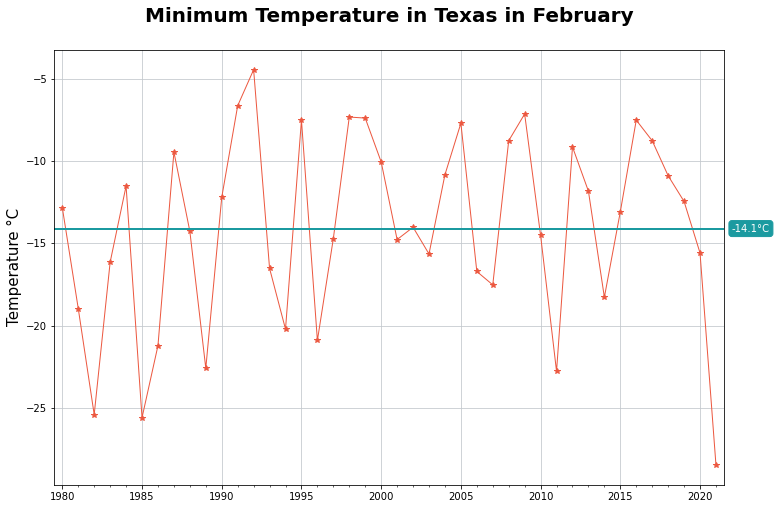

In [37]:
make_plot(feb_mins,'ECMWF ERA5','Minimum Temperature in Texas in February','°C',compare_line=np.mean(feb_mins),ylabel='Temperature °C')

Also mean temperature has been lowest in 41 year history. Also, 2010 has been relatively cold, however, as we saw from the last image, there wasnt' that low temperatures. 

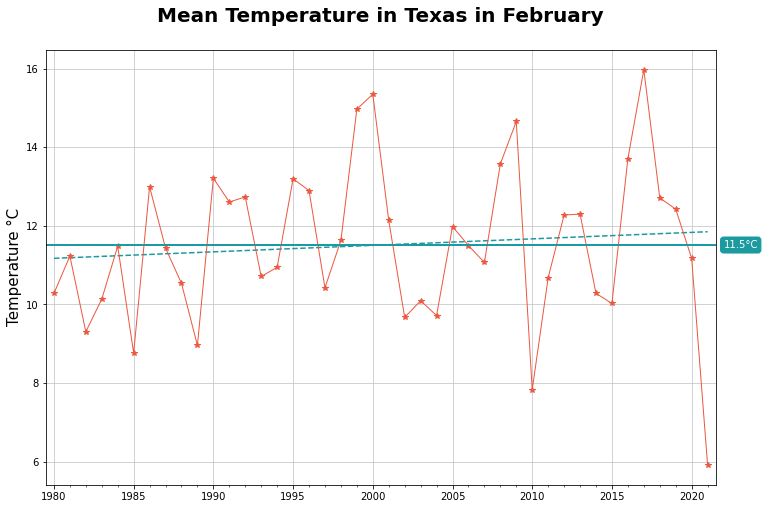

In [26]:
make_plot(feb_means,'ECMWF ERA5','Mean Temperature in Texas in February','°C',trend=True,compare_line=np.mean(feb_means),ylabel='Temperature °C')

As January can be reaally cold as well, we will look into January data as well. We can see that 1984 had very cold temperatures in January, almost as cold as 2021.

In [27]:
jan_mins = monhtly_mins.sel(time0=monhtly_mins['time0.month']==1).compute()
jan_means = monhtly_means.sel(time0=monhtly_means['time0.month']==1).compute()

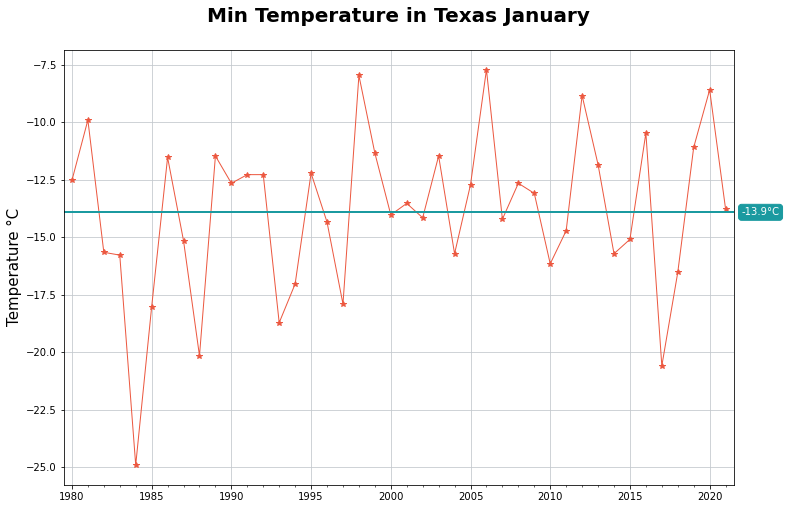

In [29]:
make_plot(jan_mins,'ECMWF ERA5','Min Temperature in Texas January','°C',compare_line=np.mean(jan_mins),
                  ylabel='Temperature °C')

From the mean temperature we can see how minimum and mean values can change the overview. 1984 has had cold days, but in overall, it wasn't that cold. On the other hand, 1985 had relatively cold January.

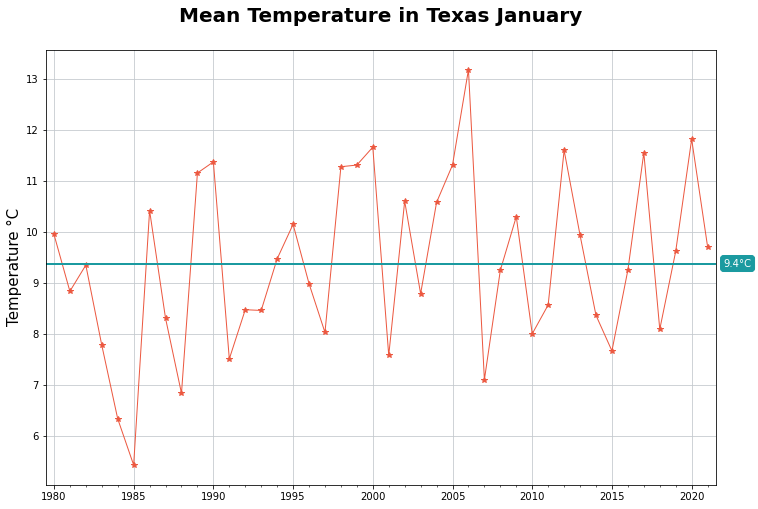

In [30]:
make_plot(jan_means,'ECMWF ERA5','Mean Temperature in Texas January','°C',compare_line=np.mean(jan_means),
                  ylabel='Temperature °C')

Let's see what happened in 2021 cold wave at daily level. 

In [31]:
current_year_data = temp_texas_appr.sel(time0=temp_texas_appr['time0.year']==2021).resample(time0="1D").mean(dim=['time0']).salem.roi(shape=shp_texas).mean(dim=['lon','lat'])

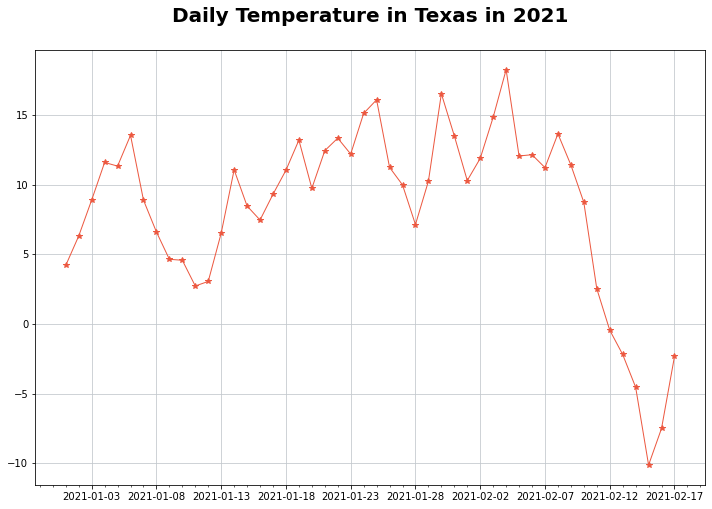

In [32]:
make_plot(current_year_data,'ECMWF ERA5','Daily Temperature in Texas in 2021','°C',daily = True)

Below we will see the coldest daily temperatures in Texas history. We will see that 15 Feb 2021 had the lowest one - -28.5 C. 

In [34]:
daily_winter_mins = temp_texas_appr.sel(time0=temp_texas_appr['time0.season']=='DJF').resample(time0="1D").min(dim=['time0']).salem.roi(shape=shp_texas).min(dim=['lon','lat']).compute()
df = daily_winter_mins.to_dataframe()
df.sort_values('air_temperature_at_2_metres').head(10)

,air_temperature_at_2_metres
time0,
2021-02-15,-28.462494
1985-02-02,-25.587494
1982-02-06,-25.399994
1984-01-18,-24.899994
1990-12-23,-23.962494
2021-02-16,-23.837494
1984-01-19,-23.774994
2011-02-10,-22.774994
1989-02-07,-22.587494


As we can see from the images above, we can see that there was very low temperatures in 2011 February as well and when looking into news, we found there were some issues with power grids. This is why we decided to look into the data on 2011 as well. We can see that temperatures really dropped pretty low, however, we can't see it much in the mean temperatures. The reason seems to be that after low temperatures in the end of Jan and beginng of February temperatures rised pretty high and this makes it warmer in average. Many days it was even above 15 C. 

In [35]:
janfeb_2011 = temp_texas_appr.sel(time0=slice('2011-01-01','2011-02-28')).resample(time0="1D").mean(dim=['time0']).salem.roi(shape=shp_texas).mean(dim=['lon','lat']).compute()

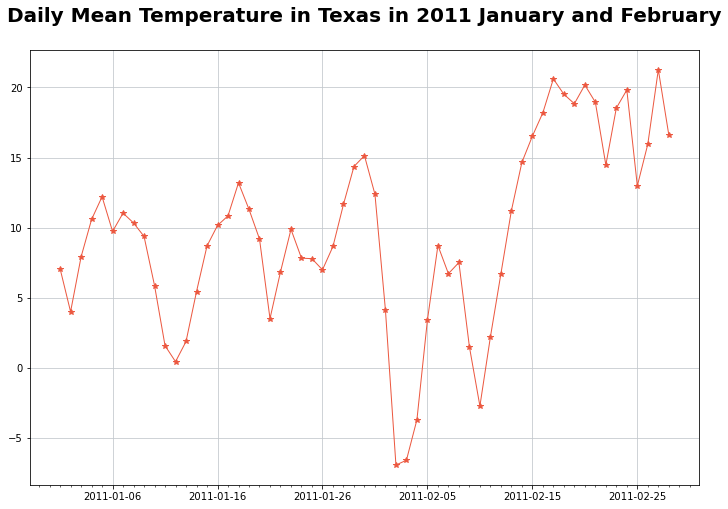

In [36]:
make_plot(janfeb_2011,'ECMWF ERA5','Daily Mean Temperature in Texas in 2011 January and February','°C',daily = True,locator = [10,1])

In [39]:
if os.path.exists(img_out):
    shutil.rmtree(img_out)

In conclusion, Texas has faced freezing temperatures before, however, they haven't made many upgrades to their power grid after 2011 blackouts. Also, 2021 February cold temperatures lasted pretty long and 2021 has coldest February in last 40 years.